In [85]:
# AOC Stats Rainclouds N-back

In [86]:
# Imports
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

from stats_helpers import (
    iqr_outlier_filter,
    mixedlm_pairwise_contrasts,
    p_to_signif
)

from importlib import reload
import stats_helpers
reload(stats_helpers)  # ensure we’re not using a cached old version
from stats_helpers import iqr_outlier_filter

from plotting_helpers import (
    add_stat_brackets,
    ensure_dir
)

In [86]:
# Setup

# I/O
input_csv  = "/Volumes/g_psyplafor_methlab$/Students/Arne/AOC/data/features/merged_data_nback.csv"
output_dir = "/Volumes/g_psyplafor_methlab$/Students/Arne/AOC/figures/stats/rainclouds"
ensure_dir(output_dir)

# Appearance (journal defaults)
pal = ["#93B8C4", "#82AD82", "#D998A2"]  # AOC pastels
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "savefig.transparent": True,
    "savefig.bbox": "tight",
    "pdf.fonttype": 42,   # TrueType; avoids Type 3 font flags in PDFs
    "ps.fonttype": 42,
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "mathtext.default": "regular",  # no auto-italics for labels like RT
})

# Inline “retina” only if running inside IPython/Jupyter (won’t crash as a script)
try:
    get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'retina'")
except Exception:
    pass

# Seaborn theme: light grid, colour-blind-safe
sns.set_theme(context="notebook", style="whitegrid")
sns.set_palette("colorblind")

# Canonical figure widths (inches)
COL = 3.35     # single column
ONEHALF = 5.0  # ~1.5 column
DOUBLE = 7.0   # double column
ASPECT = 0.72  # height = ASPECT * width (compact journal aspect)


In [87]:
# Load Data
dat = pd.read_csv(input_csv)

# Derivations / harmonisation
dat["GazeStd"] = (dat["GazeStdX"] + dat["GazeStdY"]) / 2.0

# Ensure Condition is ordered categorical “1/2/3-back”
cond_map = {1: "1-back", 2: "2-back", 3: "3-back"}
if np.issubdtype(dat["Condition"].dtype, np.number):
    dat["Condition"] = dat["Condition"].map(cond_map)
dat["Condition"] = pd.Categorical(
    dat["Condition"],
    categories=["1-back", "2-back", "3-back"],
    ordered=True
)

# Ensure ID is string/categorical for grouping
if dat["ID"].dtype != "O":
    dat["ID"] = dat["ID"].astype(str)

# Variables to plot
variables  = ["Accuracy", "ReactionTime"]
titles     = ["Accuracy", "Reaction Time"]
y_labels   = ["Accuracy [%]", "Reaction Time [s]"]
save_names = ["acc", "rt"]

# Outlier removal per condition & variable (1.5×IQR)
dat = iqr_outlier_filter(dat, variables, by="Condition")

# Pairwise comparisons in display order
comparisons = [("1-back", "2-back"), ("1-back", "3-back"), ("2-back", "3-back")]

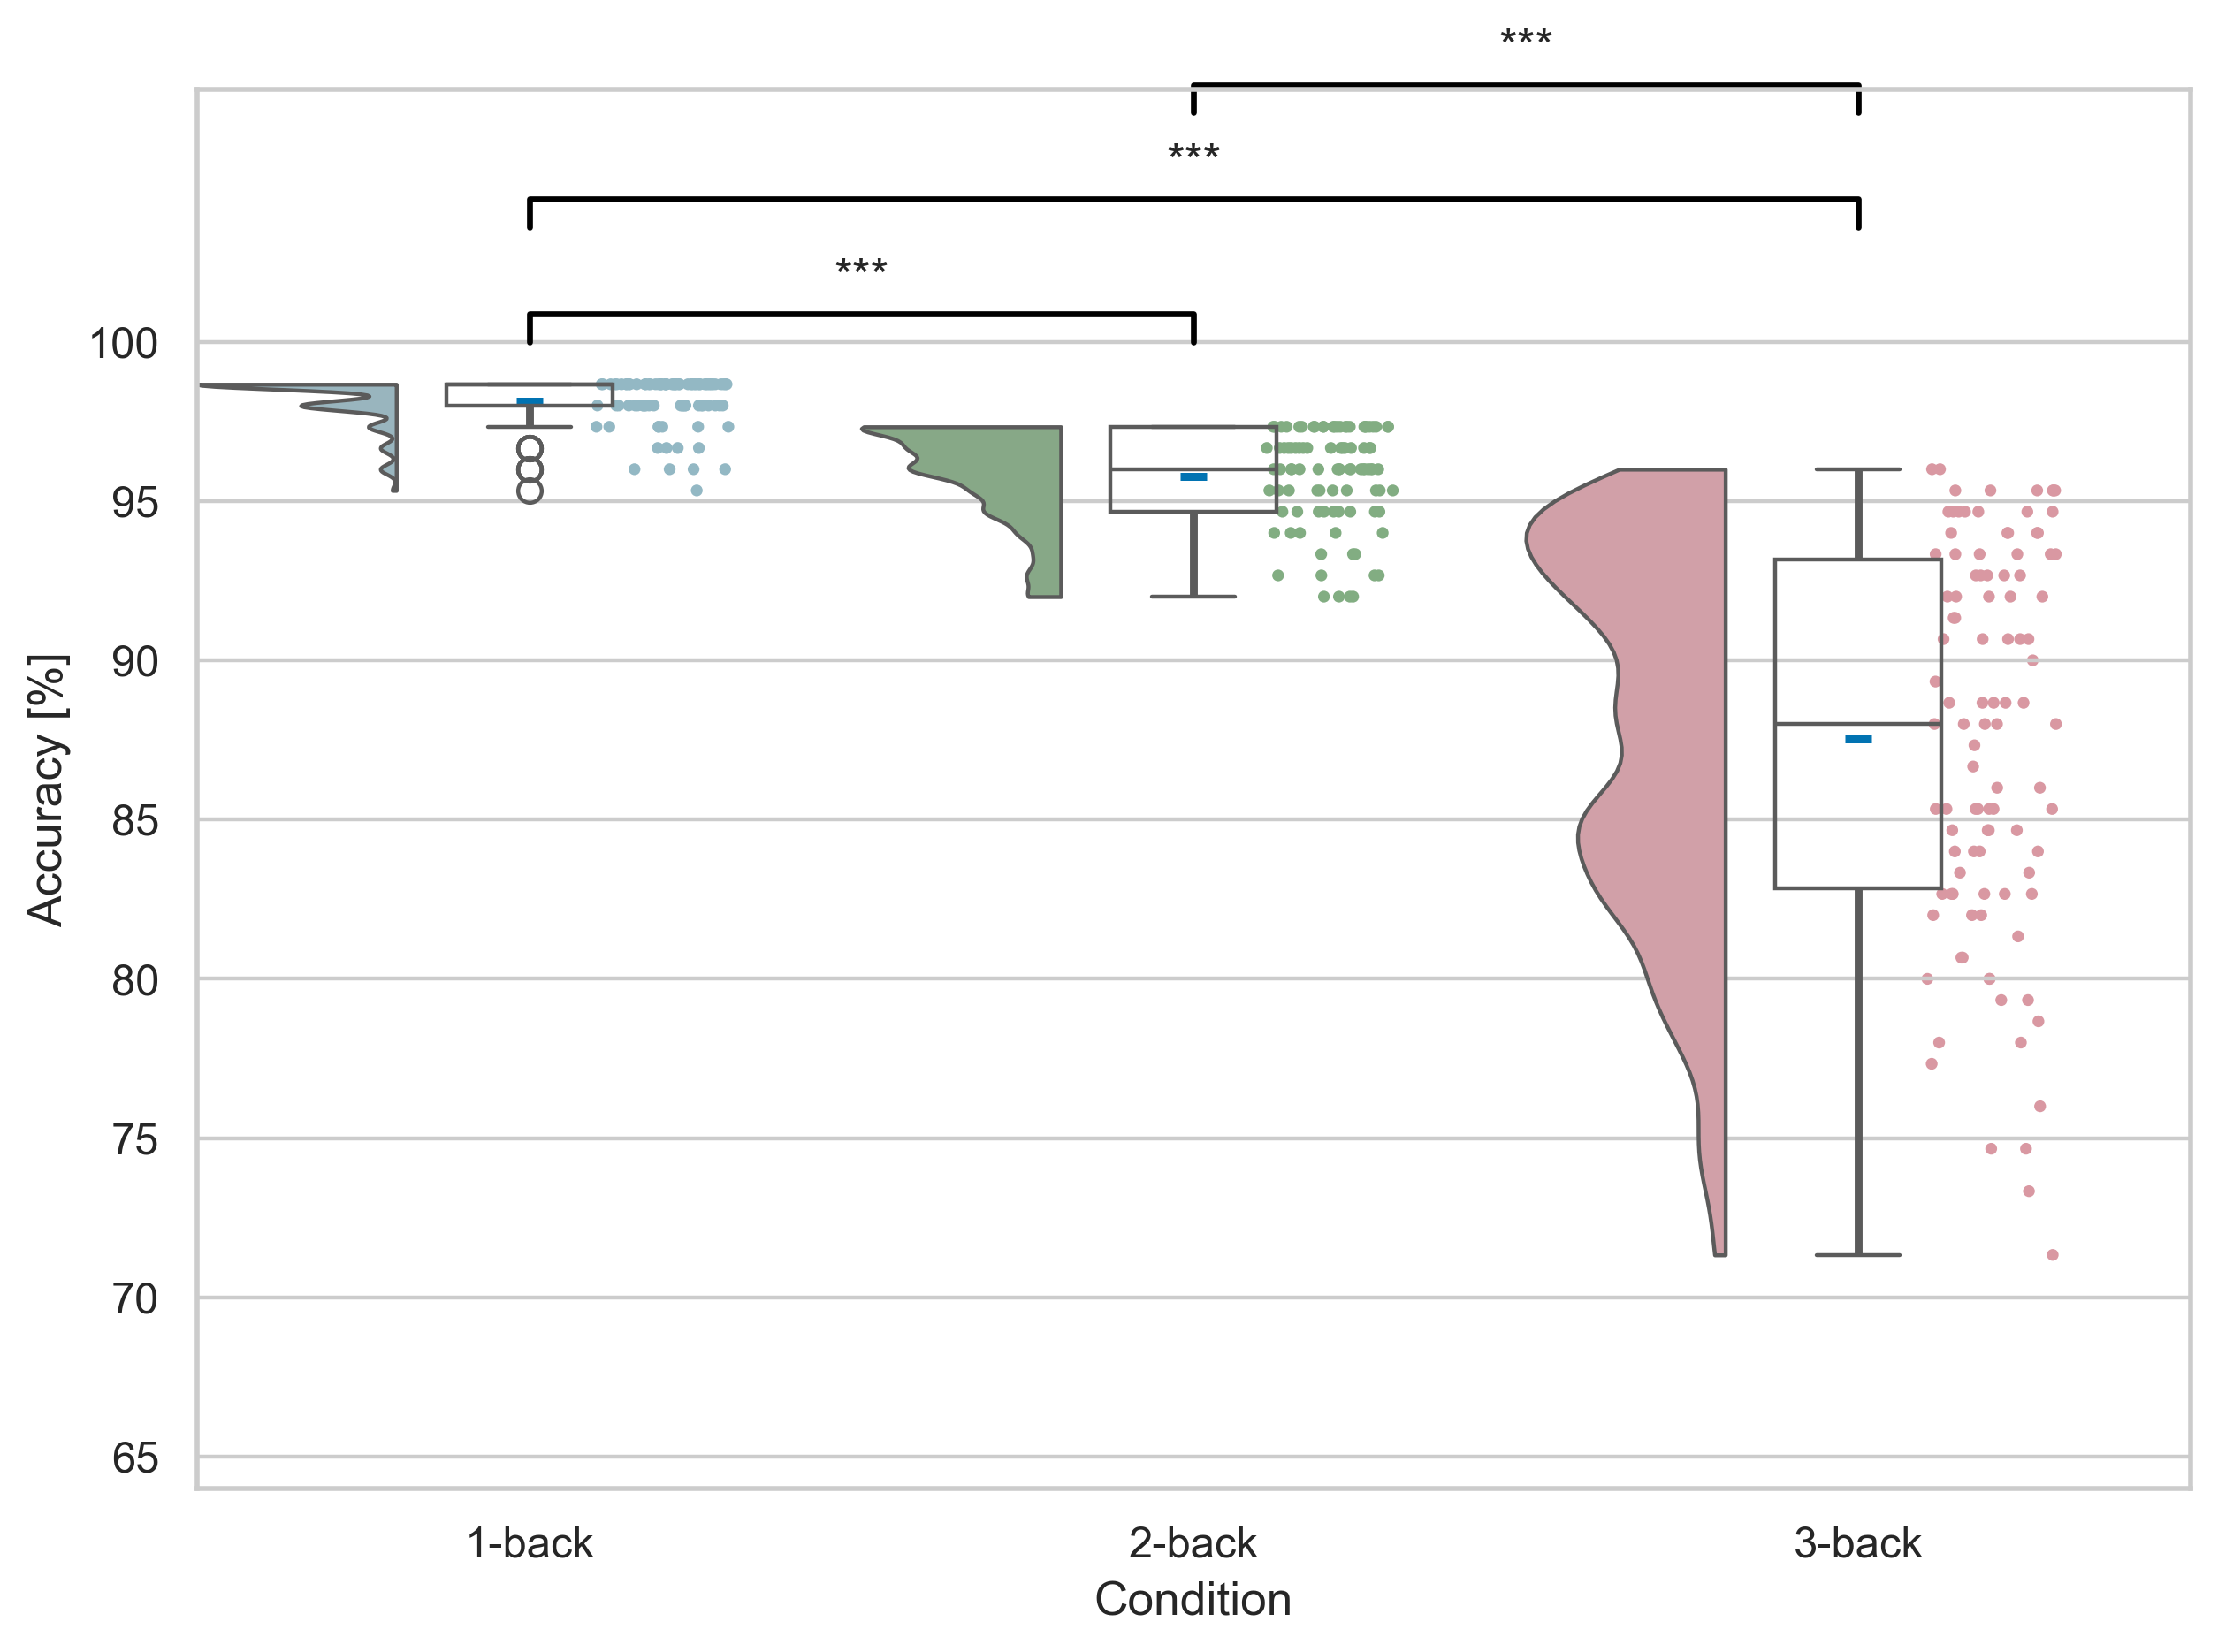

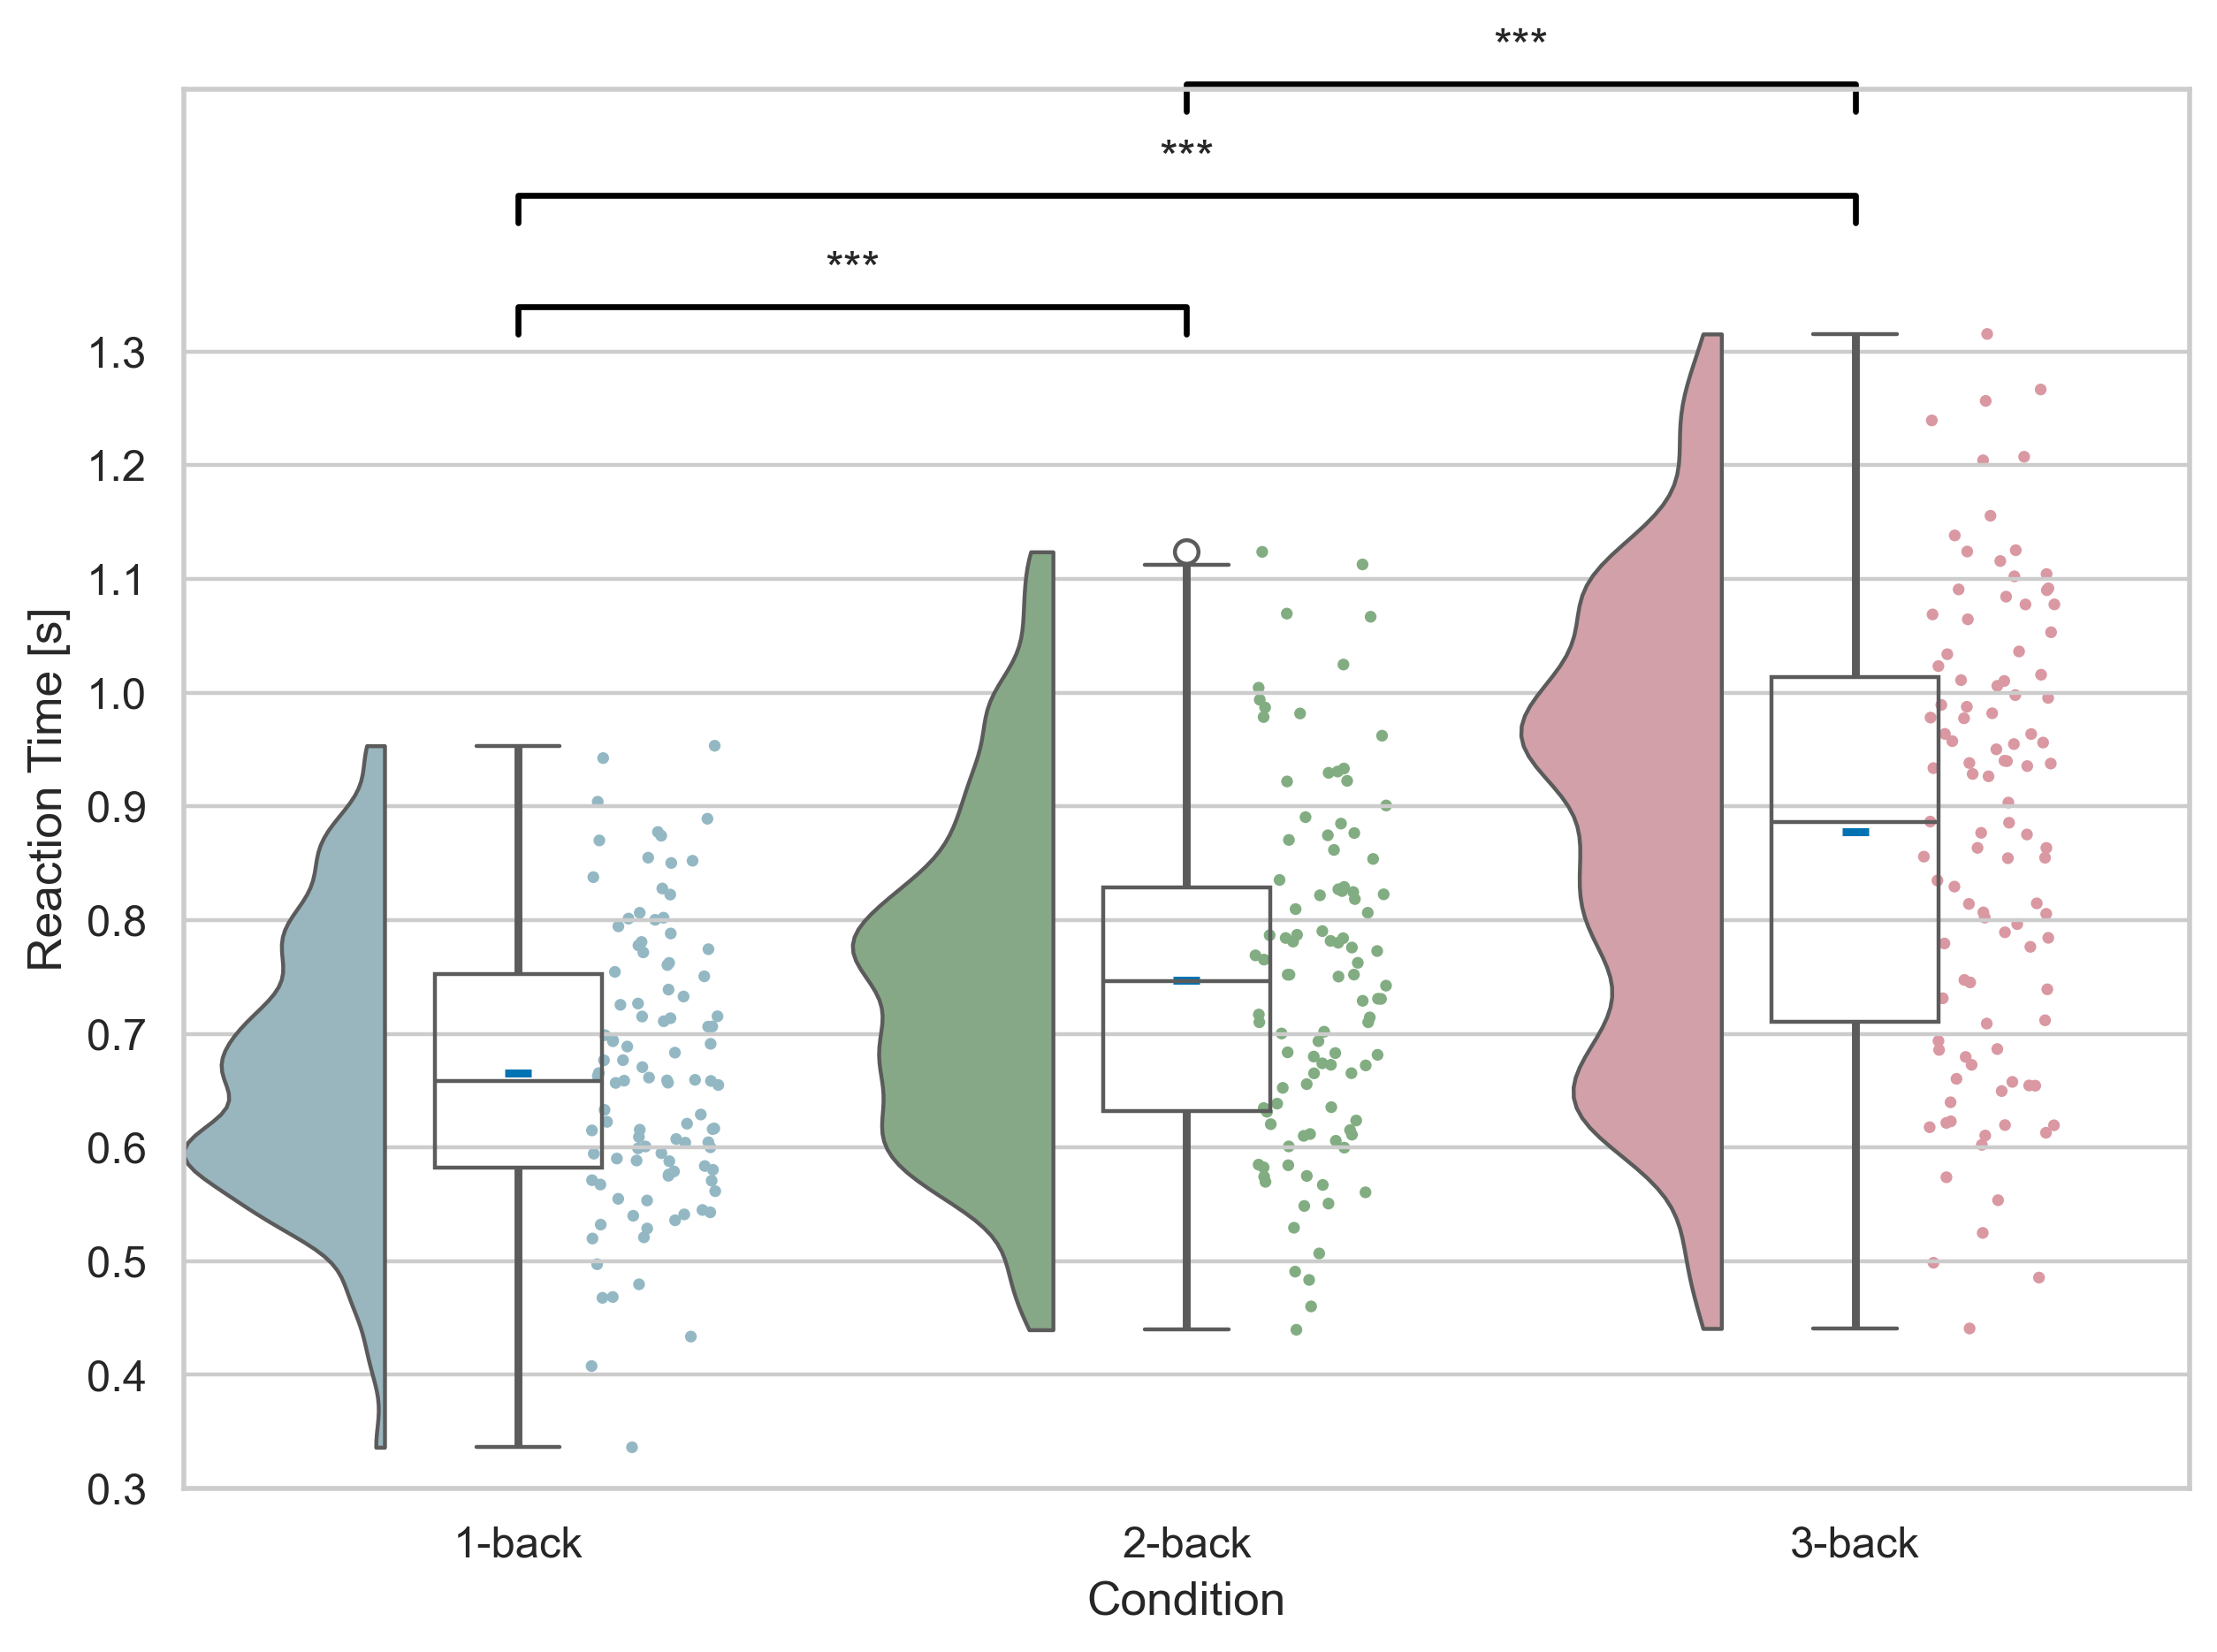

In [88]:
# Plotting

# Ensure category order once (place near your setup)
condition_order = list(dat["Condition"].dropna().unique())  # or fixed: ["1-back","2-back","3-back"]
pal_dict = dict(zip(condition_order, pal))

# Loop through variables
for var, ttl, ylab, sname in zip(variables, titles, y_labels, save_names):

    dvar = dat.loc[~dat[var].isna(), ["ID", "Condition", var]].copy()
    if dvar.empty:
        continue

    # enforce categorical order for plotting & stats
    dvar["Condition"] = pd.Categorical(dvar["Condition"], categories=condition_order, ordered=True)

    # y-limits (match R logic)
    if var == "Accuracy":
        lower_bound = 64
        nominal_upper = 100
    elif var == "GazeDeviation":
        lower_bound = 5
        nominal_upper = None
    else:
        vmin = dvar[var].min()
        vmax = dvar[var].max()
        lower_bound = vmin if np.isfinite(vmin) else None
        nominal_upper = vmax if np.isfinite(vmax) else None

    # --------------------------------
    # Base raincloud (no statistics)
    # --------------------------------
    fig, ax = plt.subplots(figsize=(8, 6))

    pt.RainCloud(
        x="Condition",
        y=var,
        hue="Condition",        # keep to satisfy seaborn deprecation
        data=dvar,
        palette=pal_dict,
        bw=.2,
        width_viol=.6,
        width_box=.25,
        move=.2,
        pointplot=False,        # avoid ptitprince's deprecated pointplot errwidth
        dodge=False,            # keep one cloud per category
        ax=ax                   # IMPORTANT: do NOT pass legend=False here
    )
    # Optional minimalist overlay (new seaborn API; silent on deprecations)
    sns.pointplot(
        x="Condition",
        y=var,
        data=dvar,
        order=condition_order,
        hue=None,
        dodge=False,
        errorbar=("ci", 95),
        err_kws={"linewidth": 0.0},
        markers="_",
        linestyles="",
        ax=ax
    )

    # Remove legend cleanly (prevents duplicate legend from hue==x)
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

    ax.set_xlabel("Condition")
    ax.set_ylabel(ylab)
    ax.set_title(ttl)

    ax.set_ylim(bottom=lower_bound)
    if var == "Accuracy":
        ax.set_yticks(np.arange(65, 101, 5))
        ymax = 100
    elif var == "ReactionTime":
        ax.set_yticks(np.round(np.arange(0.3, 1.31, 0.1), 2))
        ymax = max(dvar[var].max(), ax.get_ylim()[1])
    else:
        ymax = max(dvar[var].max(), ax.get_ylim()[1])
    ax.set_ylim(lower_bound, ymax)

    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, f"AOC_stats_rainclouds_{sname}_nback.png"), dpi=300)
    plt.close(fig)

    # --------------------------------------
    # Mixed model + pairwise contrasts (Bonf)
    # --------------------------------------
    pw = mixedlm_pairwise_contrasts(
        dvar.rename(columns={var: "value"}),
        value_col="value",
        group_col="Condition",
        id_col="ID",
        p_adjust="bonferroni"
    )

    # --------------------------------
    # Stats plot with brackets
    # --------------------------------
    fig, ax = plt.subplots(figsize=(8, 6))

    pt.RainCloud(
        x="Condition",
        y=var,
        hue="Condition",
        data=dvar,
        palette=pal_dict,
        bw=.2,
        width_viol=.6,
        width_box=.25,
        move=.2,
        pointplot=False,
        dodge=False,
        ax=ax
    )
    sns.pointplot(
        x="Condition",
        y=var,
        data=dvar,
        order=condition_order,
        hue=None,
        dodge=False,
        errorbar=("ci", 95),
        err_kws={"linewidth": 0.0},
        markers="_",
        linestyles="",
        ax=ax
    )

    # Kill the legend produced by hue==x
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

    ax.set_xlabel("Condition")
    ax.set_ylabel(ylab)
    ax.set_title("")

    # y-scaling for brackets (unchanged)
    ymin = lower_bound
    ymax_data = dvar[var].max()
    ymax_cap = nominal_upper if nominal_upper is not None else ymax_data
    ymax = max(ymax_data, ymax_cap)
    rng = ymax - ymin
    step = 0.10 * rng if rng > 0 else 1.0
    head = 0.02 * rng if rng > 0 else 0.2

    xcats = list(dvar["Condition"].cat.categories)

    y_positions = []
    start = ymax + 0.00 * rng
    for i in range(len(comparisons)):
        y_positions.append(start + i * step)

    if len(y_positions):
        ax.set_ylim(ymin, y_positions[-1] + head)
    else:
        ax.set_ylim(ymin, ymax)

    # significance labels (unchanged)
    labels = []
    for (g1, g2) in comparisons:
        row = pw.loc[(pw["group1"] == g1) & (pw["group2"] == g2)]
        labels.append("n.s." if row.empty else p_to_signif(float(row["p_adj"].iloc[0])))

    add_stat_brackets(
        ax=ax,
        xcats=xcats,
        comparisons=comparisons,
        y_positions=y_positions,
        labels=labels
    )

    if var == "Accuracy":
        ax.set_yticks(np.arange(65, 101, 5))
    elif var == "ReactionTime":
        ax.set_yticks(np.round(np.arange(0.3, 1.31, 0.1), 2))

    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, f"AOC_stats_rainclouds_{sname}_nback_stats.png"), dpi=300)